In [11]:
from math import isnan
from functools import total_ordering
import calendar
import zipfile
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings('ignore')

In [12]:
def load(asset):
    data = pd.read_csv(f'{asset}.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                   'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume', 'OpenInterest', 'IV', 'Delta', 'Gamma',
                   'Theta', 'Vega'])
    data['Expiration'] = pd.to_datetime(data['Expiration'])
    data['DataDate'] = pd.to_datetime(data['DataDate'])
    return data.loc[data['Type'] == "call"]

In [13]:
def calculate_mean_greeks(df, max_days, min_count = 100):
    greeks = {}
    for i in range(1, max_days + 1):
        frame = df[df.index.isin([i], level='Days')]
        count = frame.Delta.count()
        if count < min_count:
            continue
        delta = frame.Delta.mean()
        gamma = frame.Gamma.mean()
        theta = frame.Theta.mean()
        vega = frame.Vega.mean()
        greeks[i] = [delta, gamma, theta, vega, count]

    columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Count']
    return pd.DataFrame.from_dict(greeks, orient='index', columns=columns)

def plot_results(df):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    columns = ['Delta', 'Gamma', 'Theta', 'Vega']
    fig.set_size_inches(20, 11)
    i = 0
    for row in ax:
        for col in row:
            name = columns[i]
            col.plot(df[name])
            col.set_title(name)
            col.invert_xaxis()
            i = i + 1

    plt.show()


def select_closest_dn_option_max_expiration_days(df):
    df['Days'] = (df['Expiration'] - df['DataDate']).astype('timedelta64[D]').astype(int)
    df2 = df.groupby('DataDate').apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] - 0.5).abs().argsort()[:1]]))
    max_expiration_days = df2.loc[df2['Days'].idxmax()]['Days']
    print(f'Max days option expiration is {max_expiration_days}')
    return df2, max_expiration_days
    # return calculate_mean_greeks(df2, max_days)


def full_analysis(df, min_count = 100):
    df_dn_options, max_days = select_closest_dn_option_max_expiration_days(df)
    df_greeks = calculate_mean_greeks(df_dn_options, max_days, min_count)
    plot_results(df_greeks)
    return df_greeks

In [14]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

def asset_analysis(asset):
    print(f'Analysis for {asset}')
    df_call = load(asset)
    full_analysis(df_call)

def weekly_asset_analysis(asset):
    print(f'Weekly analysis for {asset}')
    df_call = load(asset)
    df_call['Weekday'] = df_call['DataDate'].dt.day_name()
    df_call.drop_duplicates(subset='Weekday', keep='first').filter(['Weekday'])
    greeks = {}
    for week_day in week_days:
        df_week_day = df_call.loc[df_call['Weekday'] == week_day]
        print(f'Analysis for {week_day}')
        greeks[week_day] = full_analysis(df_week_day, min_count=50)

Analysis for AMZN
Max days option expiration is 858


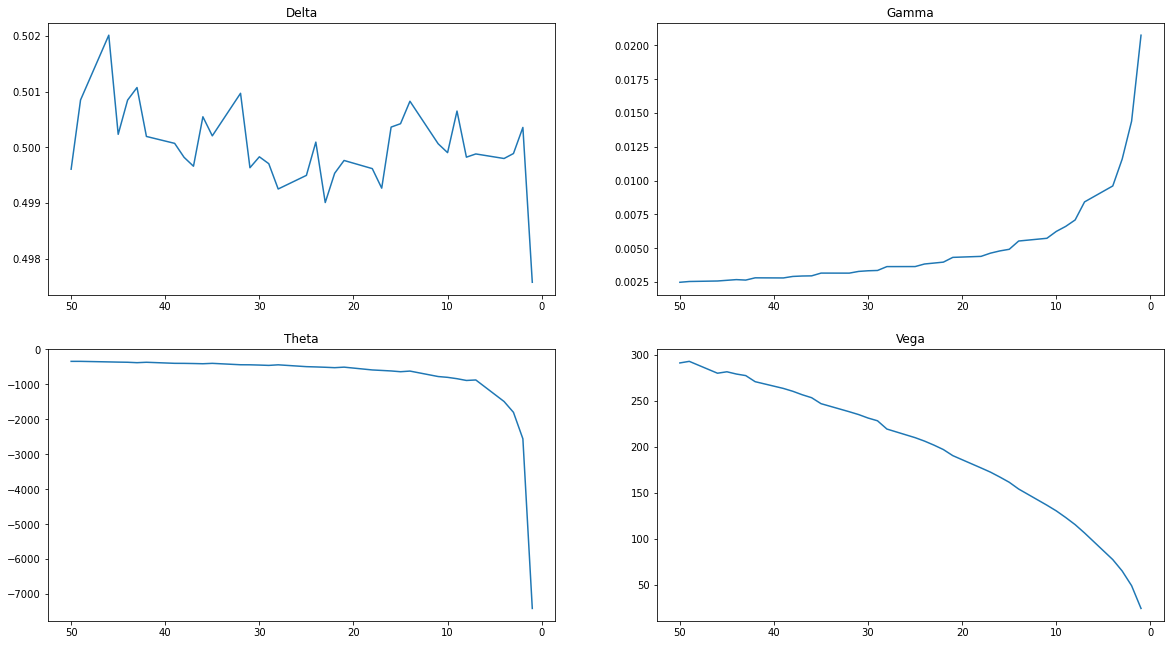

Analysis for GOOGL
Max days option expiration is 858


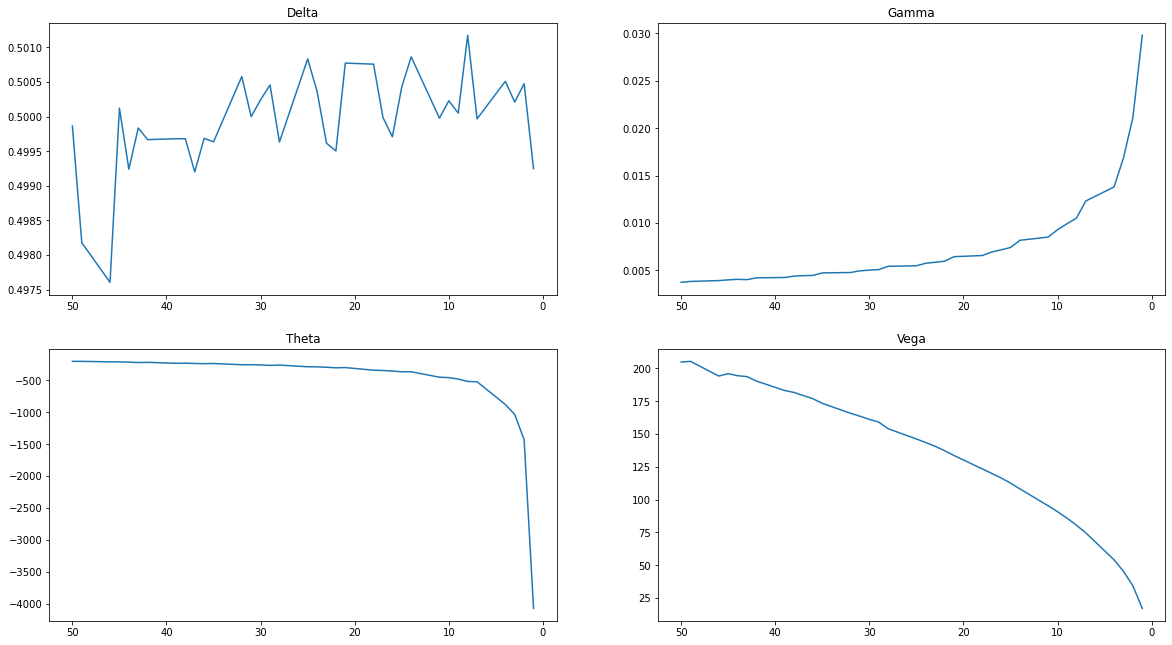

Analysis for NFLX
Max days option expiration is 858


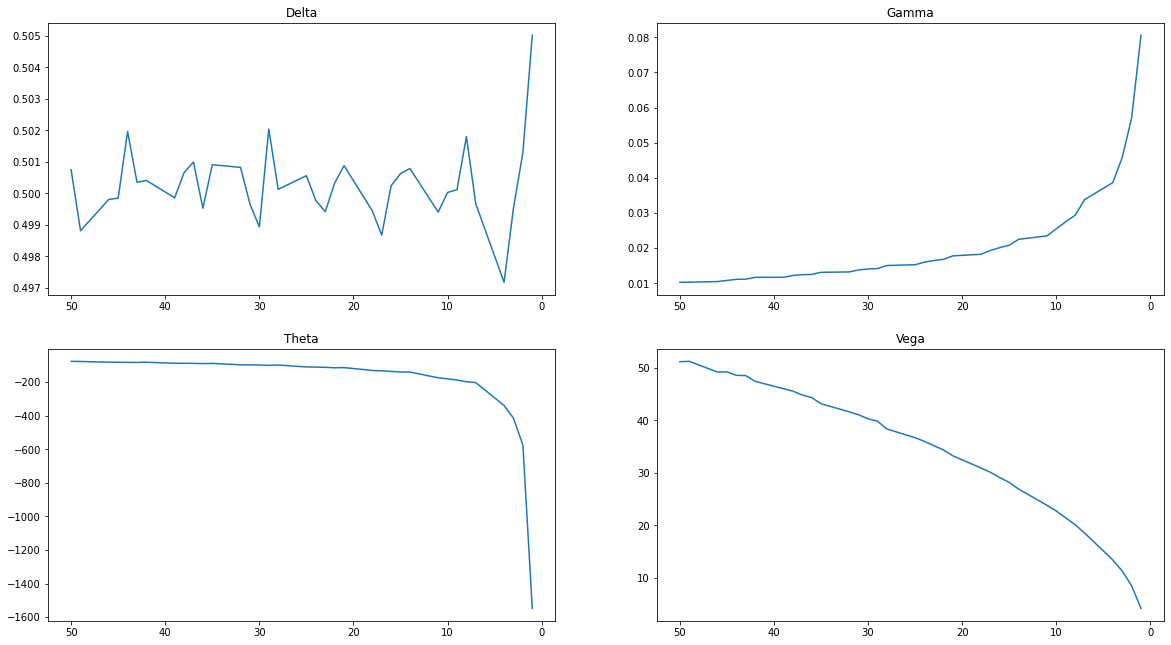

Analysis for MSFT
Max days option expiration is 945


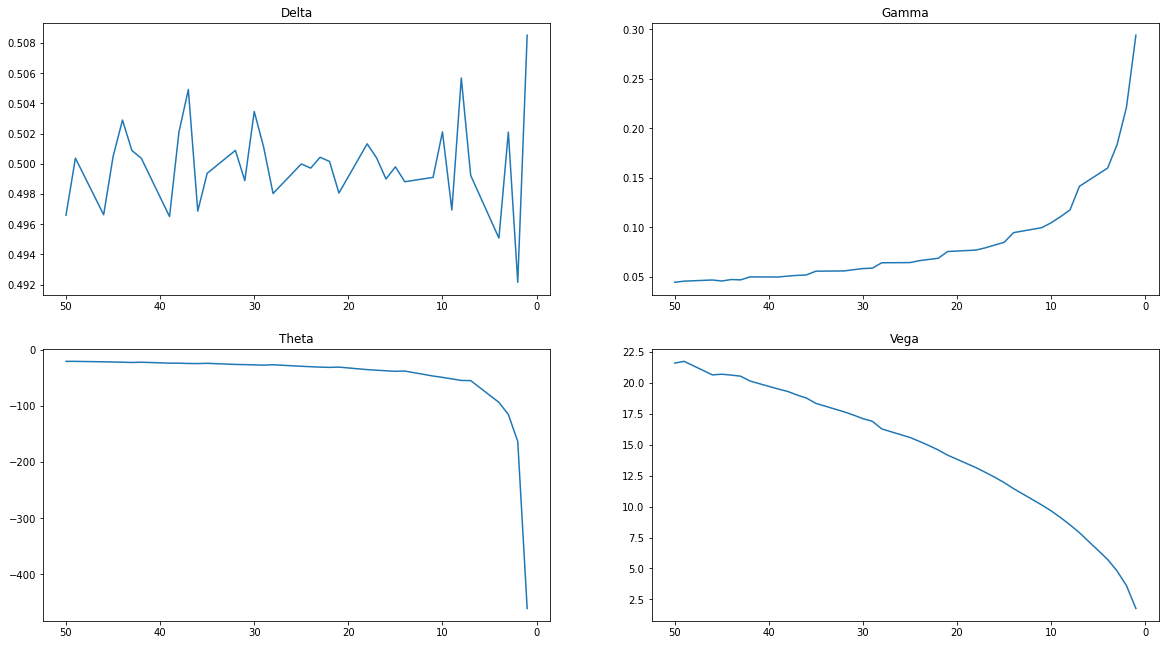

Analysis for FB
Max days option expiration is 858


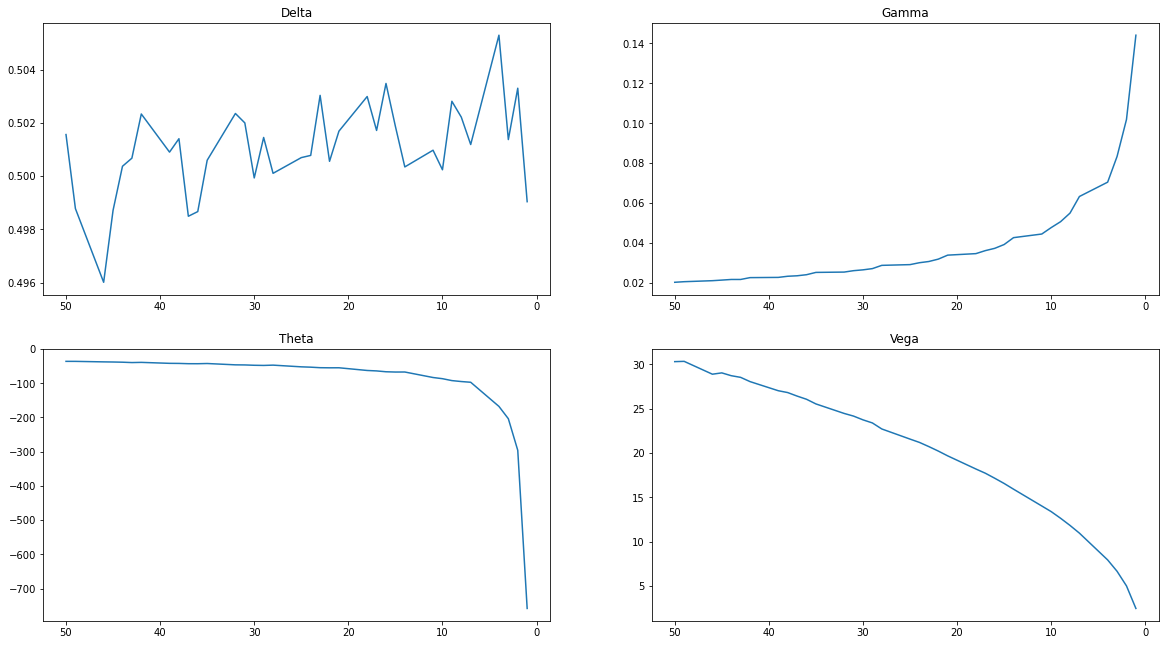

Analysis for BA
Max days option expiration is 858


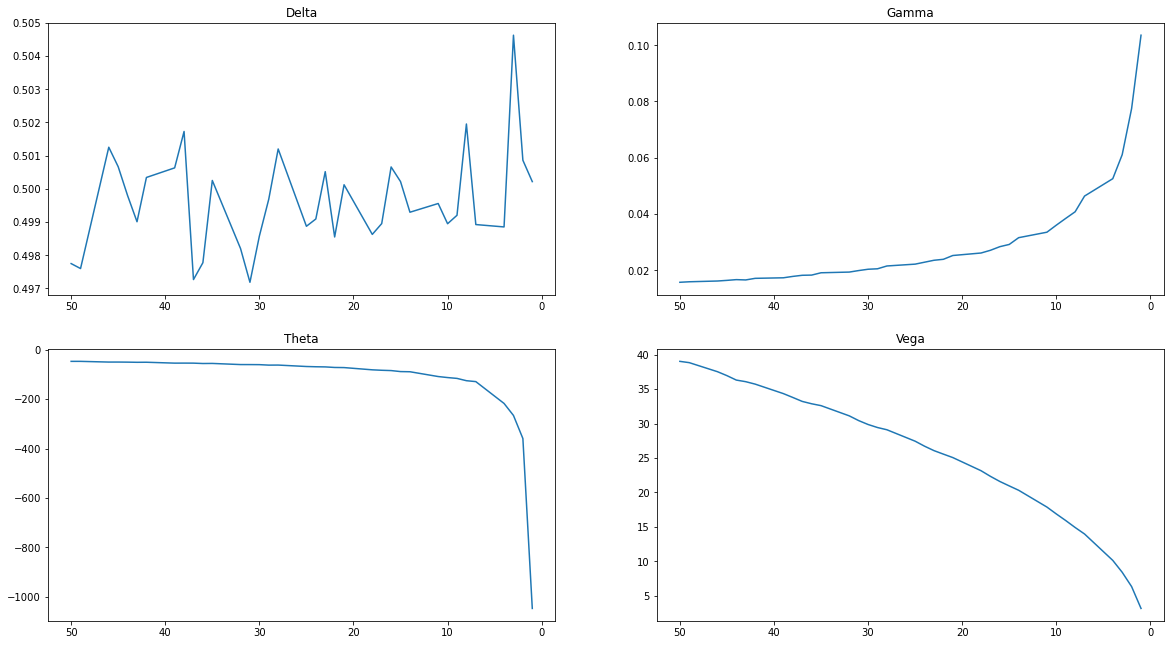

In [15]:
for asset in assets:
    asset_analysis(asset)